# Visualizing clusters
## Lecture objectives
1. Explore how to visualize and interpret clusters
2. Demonstrate radar plots
3. Provide more practice with mapping

Let's begin by recreating the clusters from the previous lecture.

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans

df = pd.read_csv('../data/c037_g20_sov_data_by_g20_srprec.csv')
df.set_index('srprec', inplace=True)

# calculate vote shares
df['Biden_pc'] = df.PRSDEM01 / (df.PRSDEM01+df.PRSREP01)*100
props = [col[3:5] for col in df.columns if col.startswith('PR_') and col.endswith('Y')]
for prop in props:
    df[prop+'_pc_yes'] = df['PR_'+prop+'_Y'] / (df['PR_'+prop+'_Y'] 
                                              + df['PR_'+prop+'_N'])*100
for prop in ['20','22']:
    df[prop+'_pc_no'] = 100 - df[prop+'_pc_yes']
    df.drop(columns=[prop+'_pc_yes'], inplace=True)

# choose columns
cols_to_plot = [col for col in df.columns if '_pc' in col]
cols_to_plot.remove('14_pc_yes') 
cols_to_plot.remove('23_pc_yes') 
cols_to_plot.remove('24_pc_yes') 

# standardize
scaler = preprocessing.StandardScaler().fit(df[cols_to_plot])
df_scaled = pd.DataFrame(scaler.transform(df[cols_to_plot]), 
                         columns=cols_to_plot, index=df.index)
df_scaled = df_scaled.dropna()

# cluster
kmeans = KMeans(n_clusters=5, random_state=1).fit(df_scaled)
df_scaled['cluster_id'] = kmeans.labels_

# verify that we got the same result as before
df_scaled.groupby('cluster_id').size()

/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_id
0    858
1    888
2    412
3     32
4    892
dtype: int64

How can we best visualize what the clusters mean? If we had just two columns, a scatterplot with a color code for each cluster would work well. But we have 10 dimensions (10 columns that are used to cluster).

One way is to redo our original scatter plot matrix, but with each cluster indicated.

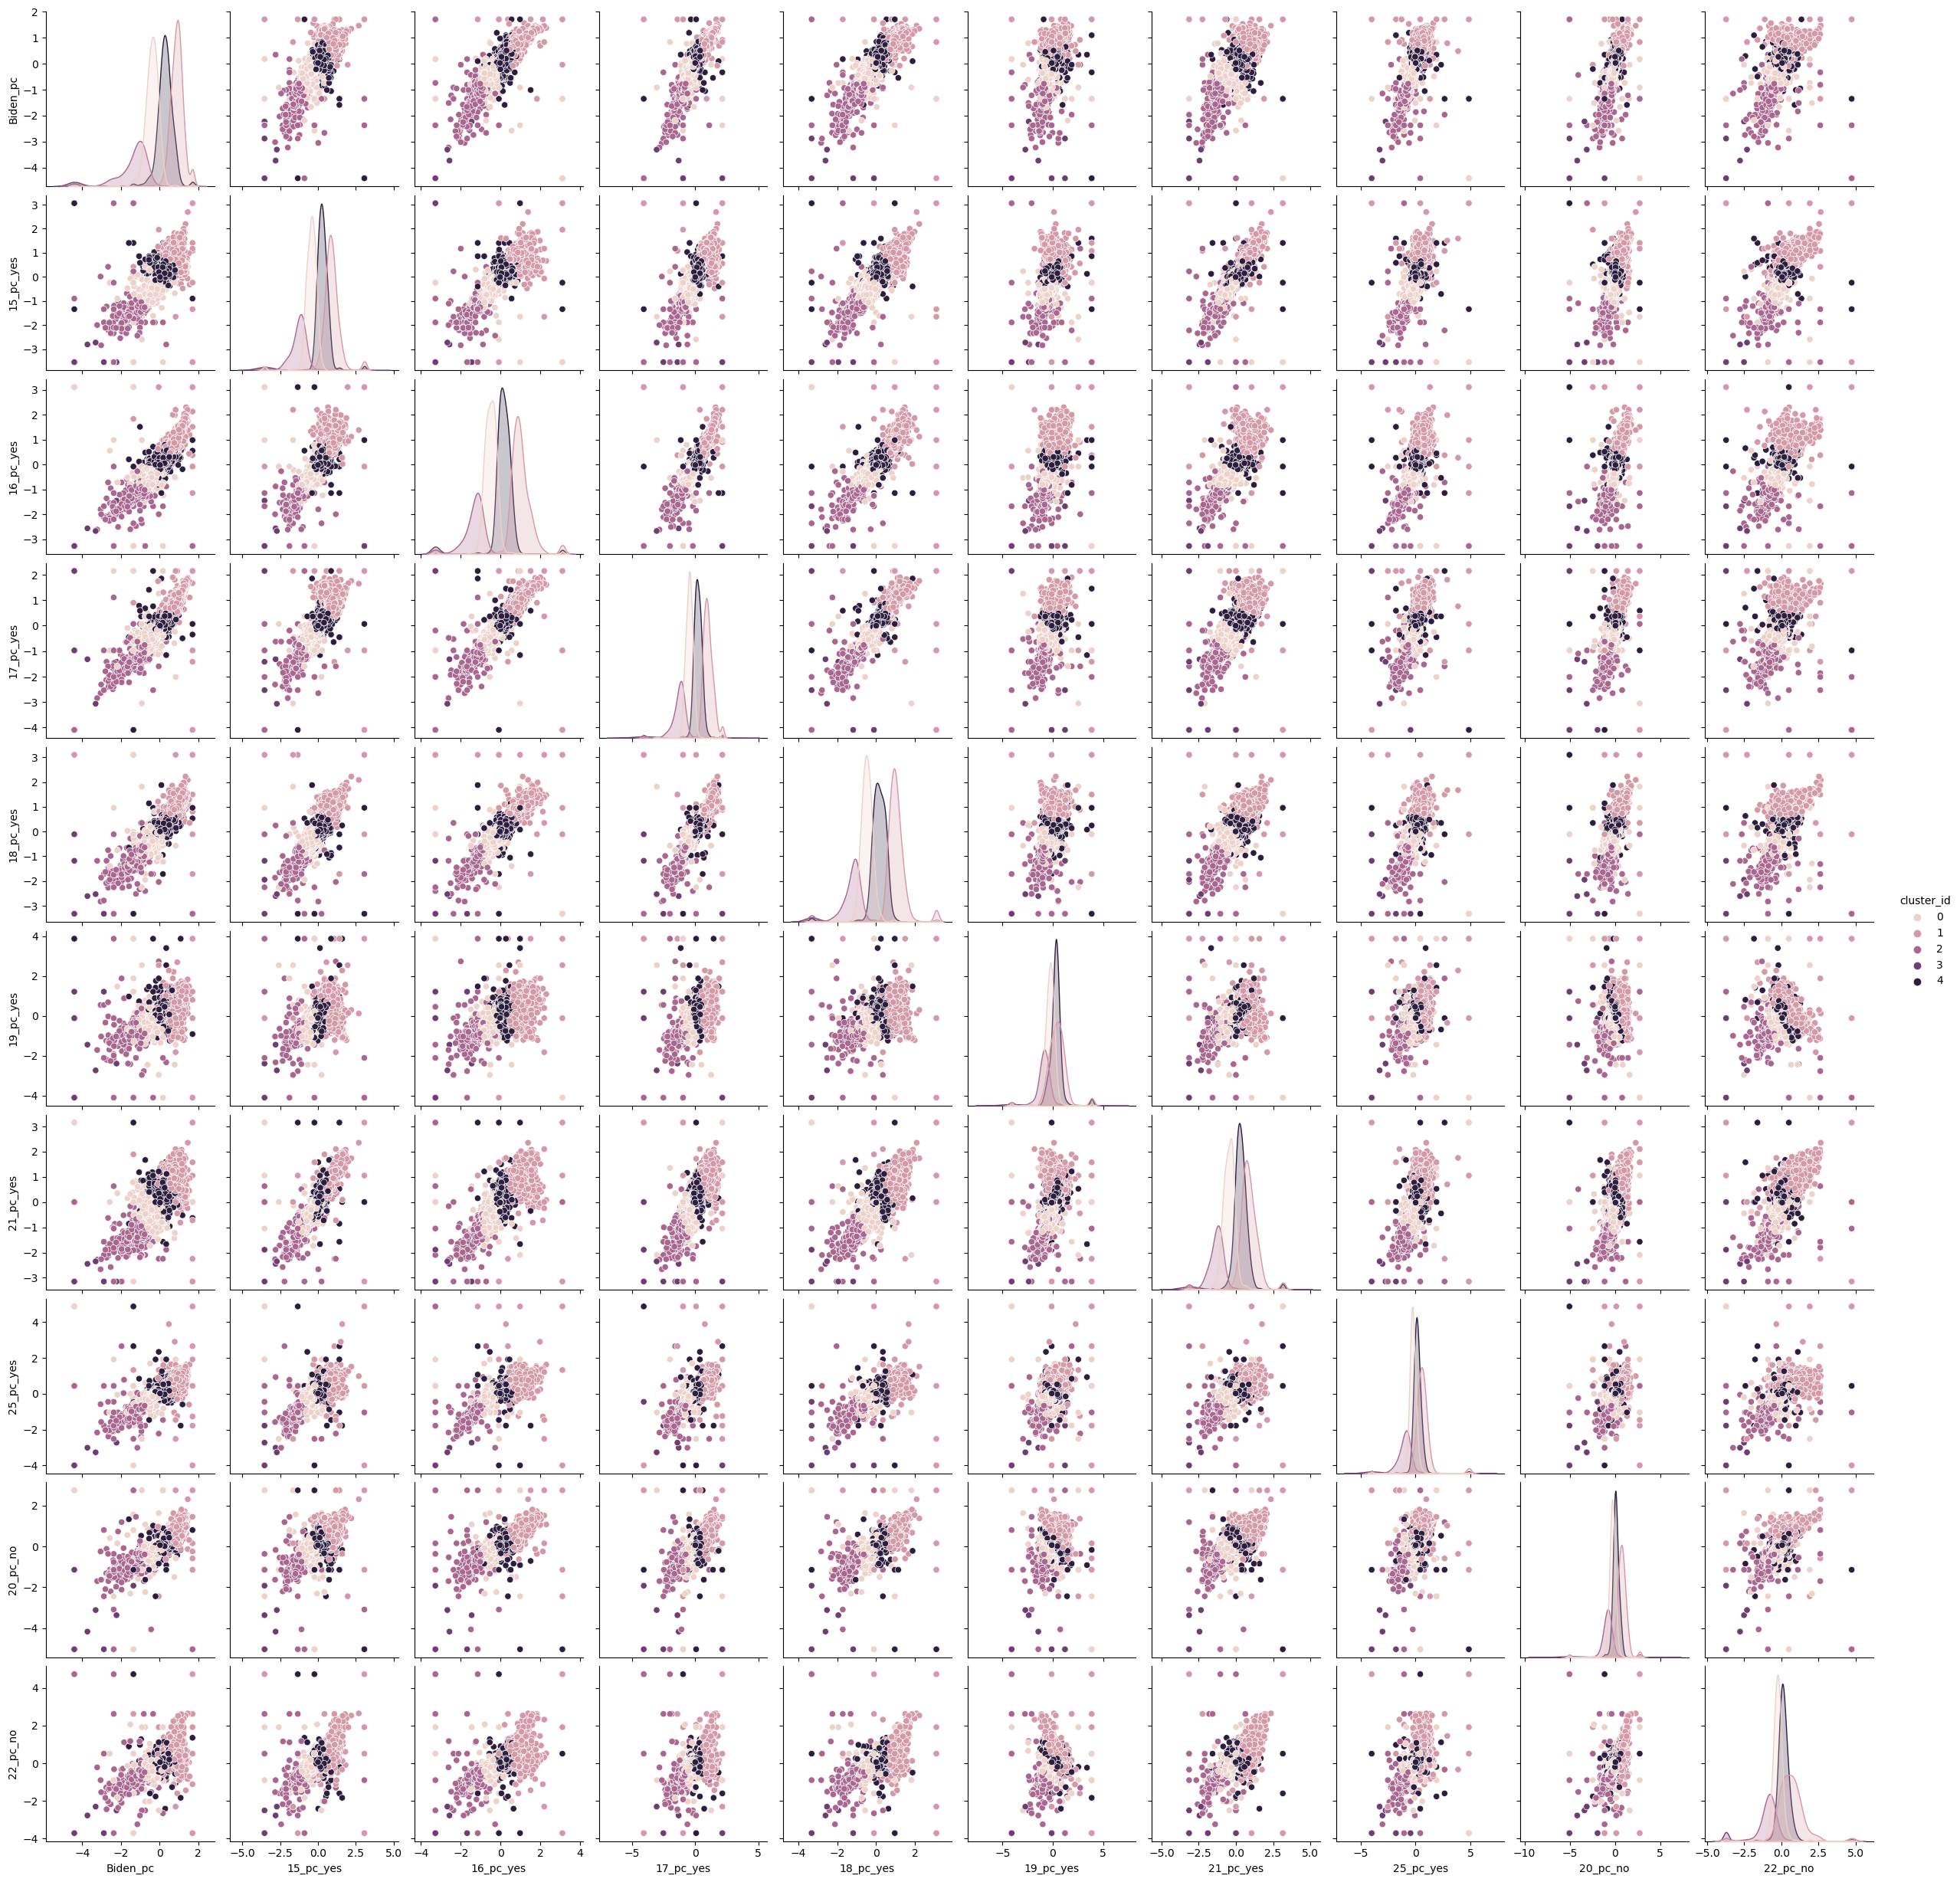

In [2]:
import seaborn as sns
ax = sns.pairplot(df_scaled, hue='cluster_id', )

My preferred option, however, is a radar chart. Neither `seaborn` nor `matplotlib` do this natively, but [there is an example in the `matplotlib` gallery](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html). I've just copied and pasted that code.

In [3]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

I then adapted the example from the website, putting it in a function called `radar_plot` that takes two arguments:
* the `kmeans` object
* the dataframe with the input data

In [4]:
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T  # the T means transpose
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(4, 4),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.95, .95),
                                labelspacing=0.1, fontsize=7)

Let's call this function with our data.

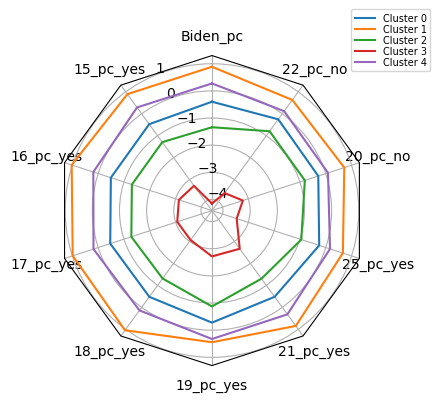

In [5]:
radar_plot(kmeans, df_scaled)

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Add the size of each cluster to the legend. <em>Hint</em>: Look at the second to last line that defines the labels. And remember that you can group by <strong>cluster_id</strong> to get the cluster sizes.
</div>

In [6]:
# get the cluster sizes as we did before
csizes = df_scaled.groupby('cluster_id').size()
# then insert that into the string
# you'd change this in the function above, not here
k = kmeans.n_clusters
labels = ['Cluster {} (N={})'.format(kk, csizes.loc[kk]) for kk in range(k)]
labels

['Cluster 0 (N=858)',
 'Cluster 1 (N=888)',
 'Cluster 2 (N=412)',
 'Cluster 3 (N=32)',
 'Cluster 4 (N=892)']

### Exploring different numbers of clusters
Here, the interesting finding is that all the clusters form concentric circles. There isn't a cluster of precincts that (say) votes against rent control but is progressive on the other items on the ballot.

We can certainly find these clusters if we increase `k`, but then these "weird" clusters have few precincts.

For example, let's try with `k=10`.

/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_id
0     18
1    726
2    919
3    632
4    290
5    428
6     15
7     29
8     13
9     12
dtype: int64


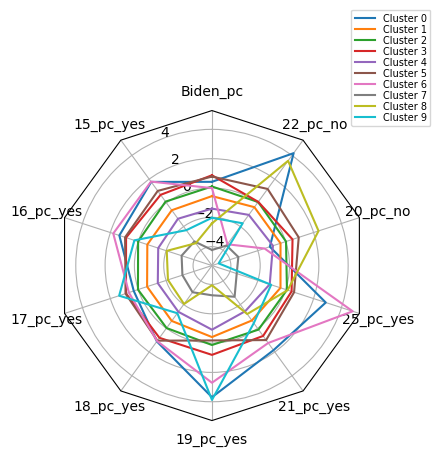

In [7]:
# drop the old cluster id, so that we don't include it in our new estimates
df_scaled.drop(columns=['cluster_id'], inplace=True)  

# this is the same code as before
kmeans = KMeans(n_clusters=10, random_state=1).fit(df_scaled)
df_scaled['cluster_id'] = kmeans.labels_
print(df_scaled.groupby('cluster_id').size())
radar_plot(kmeans, df_scaled)

Let's go back to our original 5 clusters.

/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


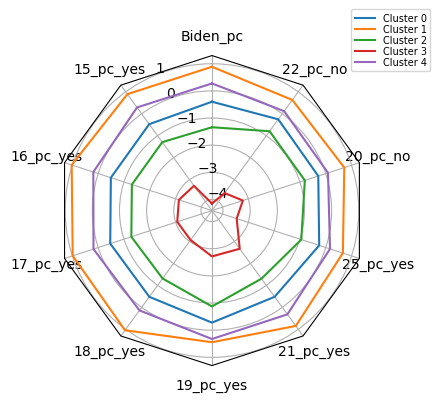

In [8]:
df_scaled.drop(columns=['cluster_id'], inplace=True) 
kmeans = KMeans(n_clusters=5, random_state=1).fit(df_scaled)
df_scaled['cluster_id'] = kmeans.labels_
radar_plot(kmeans, df_scaled)

### Mapping the clusters
The Statewide Database team provide geographic boundary files as well as the vote counts. The shapefile for Los Angeles count is in your GitHub respository.

In [9]:
import geopandas as gpd

gdf = gpd.read_file('../data/srprec_037_g20_v01_shp/srprec_037_g20_v01.shp')
gdf.head()

SRPREC                                           geometry
0  0050005A  POLYGON ((-118.18916 34.47138, -118.18969 34.4...
1  0050014A  MULTIPOLYGON (((-118.17087 34.47532, -118.1711...
2  0050022A  POLYGON ((-118.04978 34.38108, -118.05005 34.3...
3  0050024A  POLYGON ((-118.09634 34.37991, -118.09644 34.3...
4  0050025A  POLYGON ((-118.21436 34.42330, -118.21286 34.4...

Note that there is no projection file, so geopandas doesn't know the coordinate system.

In [10]:
print(gdf.crs)

None


The documentation online says it's in lat/lon, so let's set it to EPSG 4326.

In [11]:
gdf.crs = 'EPSG:4326'

Before we do a join, let's look at the data to figure out the number of rows and the join column, and whether `srprec` is a unique identifier.

In [12]:
# looks like we can join on srprec, 
# but we'll need to set that as the index for gdf
from IPython.display import display
display(df_scaled.head())
display(gdf.head())

Biden_pc  15_pc_yes  16_pc_yes  17_pc_yes  18_pc_yes  19_pc_yes  \
srprec                                                                      
0050005A -2.392682  -1.915590  -1.991738  -1.979115  -1.899401  -1.191242   
0050014A -2.395257  -2.194086  -2.119545  -2.046594  -2.019681  -1.298507   
0050022A -2.033142  -2.539322  -1.532125  -1.502205  -1.657865  -0.639951   
0050025A -1.965086  -2.216013  -0.718741  -1.596379  -2.038468   1.880973   
0050026A -4.415092  -3.534119  -3.275091  -4.091990  -3.323004  -4.101518   

          21_pc_yes  25_pc_yes  20_pc_no  22_pc_no  cluster_id  
srprec                                                          
0050005A  -1.740321  -1.925904 -1.145504 -1.113734           2  
0050014A  -1.948547  -2.105159 -1.234295 -1.268524           2  
0050022A  -1.721629  -1.339247 -0.543531 -1.608039           2  
0050025A  -3.147720   2.651168  1.189066 -0.339487           2  
0050026A  -3.147720   4.868065  2.742429  4.734721           2

SRPREC                                           geometry
0  0050005A  POLYGON ((-118.18916 34.47138, -118.18969 34.4...
1  0050014A  MULTIPOLYGON (((-118.17087 34.47532, -118.1711...
2  0050022A  POLYGON ((-118.04978 34.38108, -118.05005 34.3...
3  0050024A  POLYGON ((-118.09634 34.37991, -118.09644 34.3...
4  0050025A  POLYGON ((-118.21436 34.42330, -118.21286 34.4...

In [13]:
# we have more observations in our spatial data, so we can do a left join to that
# maybe some precincts have no voters?
print(len(gdf))
print(len(df_scaled))

3383
3082


In [14]:
# both are unique, which makes things easier
print(df_scaled.index.is_unique)
print(gdf.SRPREC.is_unique)

True
True


In [15]:
# do the join
gdf.set_index('SRPREC', inplace=True)
joinedGdf = gdf.join(df_scaled)
joinedGdf.head()

geometry  Biden_pc  \
SRPREC                                                                  
0050005A  POLYGON ((-118.18916 34.47138, -118.18969 34.4... -2.392682   
0050014A  MULTIPOLYGON (((-118.17087 34.47532, -118.1711... -2.395257   
0050022A  POLYGON ((-118.04978 34.38108, -118.05005 34.3... -2.033142   
0050024A  POLYGON ((-118.09634 34.37991, -118.09644 34.3...       NaN   
0050025A  POLYGON ((-118.21436 34.42330, -118.21286 34.4... -1.965086   

          15_pc_yes  16_pc_yes  17_pc_yes  18_pc_yes  19_pc_yes  21_pc_yes  \
SRPREC                                                                       
0050005A  -1.915590  -1.991738  -1.979115  -1.899401  -1.191242  -1.740321   
0050014A  -2.194086  -2.119545  -2.046594  -2.019681  -1.298507  -1.948547   
0050022A  -2.539322  -1.532125  -1.502205  -1.657865  -0.639951  -1.721629   
0050024A        NaN        NaN        NaN        NaN        NaN        NaN   
0050025A  -2.216013  -0.718741  -1.596379  -2.038468   1.880973  -3.147720   

          25_pc_yes  20_pc_no  22_pc_no  cluster_id  
SRPREC                                               
0050005A  -1.925904 -1.145504 -1.113734         2.0  
0050014A  -2.105159 -1.234295 -1.268524         2.0  
0050022A  -1.339247 -0.543531 -1.608039         2.0  
0050024A        NaN       NaN       NaN         NaN  
0050025A   2.651168  1.189066 -0.339487         2.0

Let's map the clusters. We should color code by `cluster_id`.

Text(0.5, 1.0, 'Typology of voting, 2020 General Election')

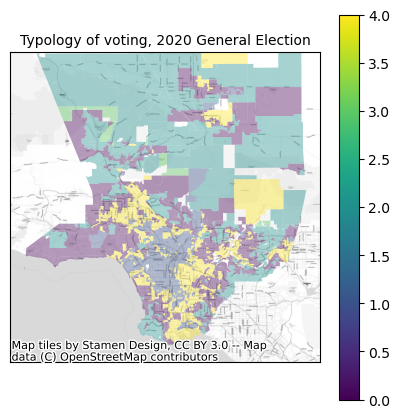

In [16]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

joinedGdf.to_crs('EPSG:3857').plot('cluster_id', legend=True, ax = ax, alpha=0.4)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)

# drop Catalina Island
ax.set_ylim([3.98e6, 4.14e6])

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Typology of voting, 2020 General Election', fontsize=10)

What can we do to improve the map?

The `source` keyword gives access to lots of options. Take a look at the possibilities with `ctx.providers`.

In [17]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<ins

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> How else would you improve the map?
</div>

There's no right answer here, but I first replace the missing data with an explicit "no data" label. To do that, we need to change the data type of `cluster_id` to string.

We can also remove the decimal point from the other cluster labels using the `str.replace()` function. We replace `.0` with an empty string.

In [18]:
joinedGdf.cluster_id = joinedGdf.cluster_id.astype(str)
joinedGdf.cluster_id = joinedGdf.cluster_id.str.replace('.0', '')
joinedGdf.cluster_id = joinedGdf.cluster_id.str.replace('nan', 'No data')

joinedGdf.cluster_id.head()

/var/folders/cx/5hr478816plb9gd8v3v207d40000gn/T/ipykernel_90024/2829624228.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  joinedGdf.cluster_id = joinedGdf.cluster_id.str.replace('.0', '')


SRPREC
0050005A          2
0050014A          2
0050022A          2
0050024A    No data
0050025A          2
Name: cluster_id, dtype: object

In the plot itself, we might:
* replace the colorbar with a legend. This is because we have discrete categories (0-5), not a continuous variable. That is done with the `categorical=True` keyword argument.
* add a legend title. We get the legend and then use the `set_title()` function.
* specify the colors. I find https://colorbrewer2.org the most helpful. 
* specify a gray for missing data (a grayscale color is a string between 0 and 1. E.g. 0 is black and 1 is white, with values in between representing progressively lighter shades.

[]

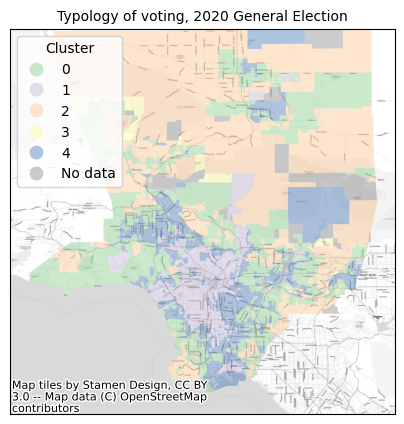

In [19]:
# getting the colors into a colormap required some searching
# https://stackoverflow.com/questions/38882233/geopandas-matplotlib-plot-custom-colors
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(5,5))
joinedGdf.to_crs('EPSG:3857').plot('cluster_id', ax=ax, categorical=True, 
                                  legend=True, alpha=0.4, cmap=cmap,
                                  legend_kwds={'loc': 'upper left'})

# add a legend title
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':10} )

# all this is the same as before
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of voting, 2020 General Election', fontsize=10)                           
ax.set_ylim([3.98e6, 4.14e6])
ax.set_xticks([])
ax.set_yticks([])

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Even if the clusters are pretty self-explanatory, they can be useful</li>
  <li>Radar plots and maps are two useful visualizations that help you interpret your clusters.
  <li>They can be a starting point for further quantitative research—perhaps, use them as a variable in a regression model</li>
  <li>They can also be useful for qualitative research. Perhaps you might do a case study of each cluster, picking the precinct/city/agency that is closest to each cluster center</li>
</ul>
</div>